# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

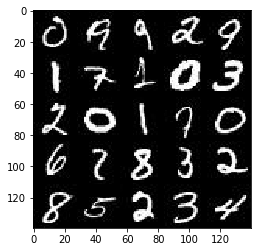

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

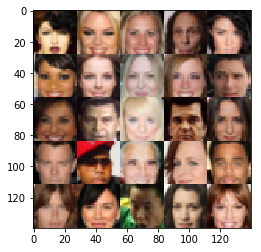

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # Arbitrarily defining an alpha parameter for Leaky ReLU
    alpha = 0.15
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Arbitrarily defining an alpha parameter for Leaky ReLU
    alpha = 0.15
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        fc = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(fc, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x? now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Setting our image dimensions as separate variables
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    # Setting image depth (channels)
    image_channels = 1
    if (data_image_mode == 'L'):
        image_channels = 1
    elif (data_image_mode == 'RGB'):
        image_channels = 3
    
    # Create input placeholders
    input_real, input_z, lr = model_inputs(image_width,
                                           image_height,
                                           image_channels,
                                           z_dim)

    # Create loss functions for both generator and discriminator
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Create optimizers for both generator and discriminator
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # iteration counter
    steps = 0
    # how many steps need to print errors
    print_every = 10
    # how many steps needed to show generated images
    show_every = 100
    # how many generated images should be shown
    show_n_images = 36
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps+=1
                # normalizing input images to (-1,1), as they are originally in (-0.5,0.5) format
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     lr: learning_rate})

                # print errors every "print_every" steps
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # show sample generated images every "show_every" steps
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
    
        # show enging sample images
        show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
    
    # print ending message
    print("model trained")
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 11.7984
Epoch 1/2... Discriminator Loss: 0.5678... Generator Loss: 17.3907
Epoch 1/2... Discriminator Loss: 7.8975... Generator Loss: 0.0008
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 7.2400
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 9.5874
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 1.9357
Epoch 1/2... Discriminator Loss: 0.4819... Generator Loss: 2.6377
Epoch 1/2... Discriminator Loss: 0.4487... Generator Loss: 3.3395
Epoch 1/2... Discriminator Loss: 0.3723... Generator Loss: 4.5337
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 2.2810


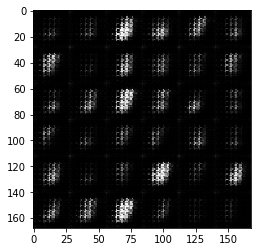

Epoch 1/2... Discriminator Loss: 0.5800... Generator Loss: 2.1322
Epoch 1/2... Discriminator Loss: 0.5160... Generator Loss: 2.3587
Epoch 1/2... Discriminator Loss: 0.6430... Generator Loss: 4.9939
Epoch 1/2... Discriminator Loss: 2.8006... Generator Loss: 11.6455
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 2.0335
Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.8950
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 3.8308
Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 4.7820
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.8511


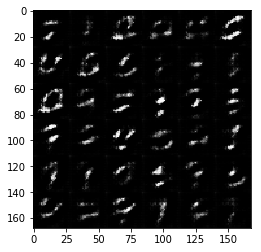

Epoch 1/2... Discriminator Loss: 0.6508... Generator Loss: 2.9136
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 2.4594
Epoch 1/2... Discriminator Loss: 1.7388... Generator Loss: 0.5003
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.2700
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 1.7427
Epoch 1/2... Discriminator Loss: 0.8445... Generator Loss: 2.1525
Epoch 1/2... Discriminator Loss: 2.2839... Generator Loss: 0.3148
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 1.8559
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.8681


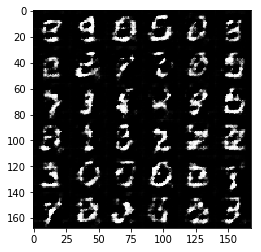

Epoch 1/2... Discriminator Loss: 1.4609... Generator Loss: 3.2177
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 2.0720
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 2.2266
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 0.8458
Epoch 1/2... Discriminator Loss: 0.8997... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 1.8328... Generator Loss: 3.6180
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 1.1960
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 2.4418
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 2.2513
Epoch 1/2... Discriminator Loss: 1.8187... Generator Loss: 0.3671


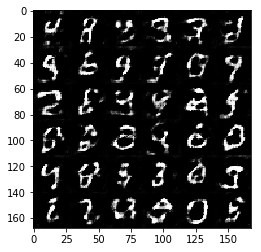

Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.0081
Epoch 1/2... Discriminator Loss: 0.8487... Generator Loss: 1.5431
Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 1.7100
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 2.0426
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.5273
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 1.0499
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 0.9192... Generator Loss: 1.2971
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.1301


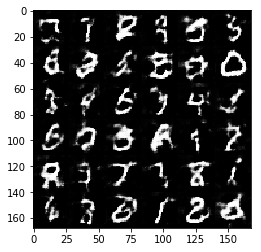

Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 1.2918
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 1.3332
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 1.3688
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 1.5603
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 2.5388
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 0.9766... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.6720


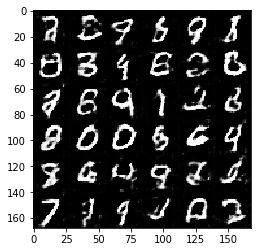

Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 2.2601
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 1.0124
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 2.2547
Epoch 1/2... Discriminator Loss: 1.5573... Generator Loss: 0.4375
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 1.2514
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 1.1063
Epoch 1/2... Discriminator Loss: 2.0486... Generator Loss: 0.2645
Epoch 1/2... Discriminator Loss: 0.9103... Generator Loss: 1.4515
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.7443


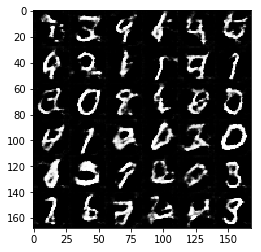

Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.9340
Epoch 1/2... Discriminator Loss: 0.8772... Generator Loss: 1.2632
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 0.9875
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 1.2199
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.7159
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 1.8922
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 1.1657... Generator Loss: 0.7060


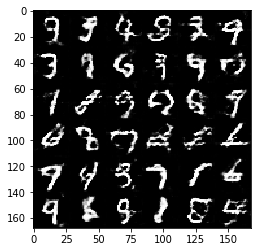

Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.0868
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.6742... Generator Loss: 3.5463
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 1.0429
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 1.9030
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 1.2645


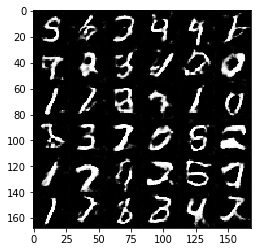

Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.4816
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.8219
Epoch 1/2... Discriminator Loss: 0.9236... Generator Loss: 1.3087
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 1.1225
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 2.3477
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.1569... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 3.4623... Generator Loss: 5.3730
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.4627
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 1.9891


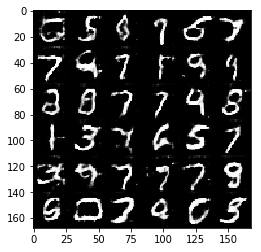

Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 2.0186
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 1.6389... Generator Loss: 3.2255
Epoch 2/2... Discriminator Loss: 1.1520... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.3027


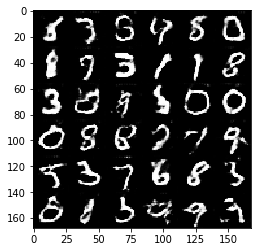

Epoch 2/2... Discriminator Loss: 1.7489... Generator Loss: 3.2448
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 1.8613
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 2.0510
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.1511
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 0.9973


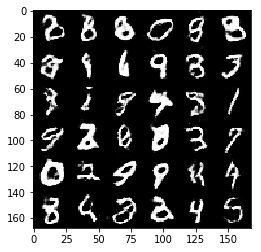

Epoch 2/2... Discriminator Loss: 0.8111... Generator Loss: 1.2931
Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 0.8340
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 0.9578... Generator Loss: 1.0306
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 2.6655
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.1134
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.9490
Epoch 2/2... Discriminator Loss: 0.9593... Generator Loss: 1.1856


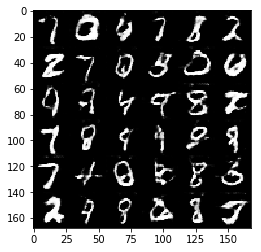

Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 1.1852
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 2.0496
Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 1.1689
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.9331
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.0518
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 1.0650
Epoch 2/2... Discriminator Loss: 0.9640... Generator Loss: 0.8813
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 3.7814... Generator Loss: 0.0673


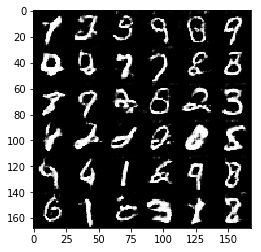

Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.7134
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.5677
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 2.2431
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 1.4812... Generator Loss: 0.5958
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 2.0681
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 1.3429
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.4454
Epoch 2/2... Discriminator Loss: 0.9105... Generator Loss: 1.5332


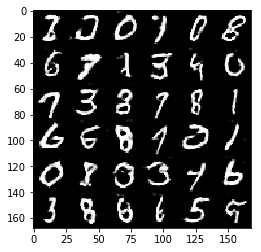

Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 1.6687... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 3.9084
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 1.7559... Generator Loss: 0.3845
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.3045
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 1.1528
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.8461
Epoch 2/2... Discriminator Loss: 0.9541... Generator Loss: 1.2417


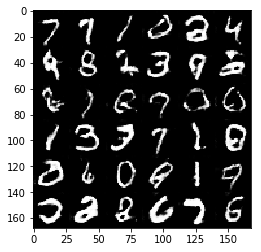

Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 1.7900
Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 2.7354
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.9293
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 0.6845... Generator Loss: 1.7697
Epoch 2/2... Discriminator Loss: 0.6571... Generator Loss: 2.3972
Epoch 2/2... Discriminator Loss: 0.8292... Generator Loss: 1.5069
Epoch 2/2... Discriminator Loss: 3.2621... Generator Loss: 5.4109
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.6453


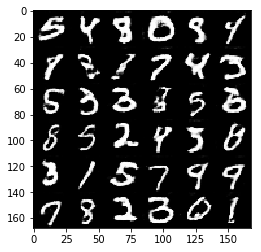

Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.2880
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 1.9693... Generator Loss: 0.4258
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 2.3996
Epoch 2/2... Discriminator Loss: 0.6723... Generator Loss: 1.5659
Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 1.6994
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 2.2280
Epoch 2/2... Discriminator Loss: 0.5097... Generator Loss: 2.0479
Epoch 2/2... Discriminator Loss: 1.4941... Generator Loss: 3.0772
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 1.7636


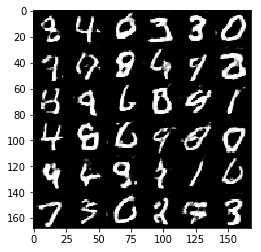

Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 1.2122
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 0.9605
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 0.6421... Generator Loss: 2.0257
Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 1.7136
Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.8037
Epoch 2/2... Discriminator Loss: 1.0632... Generator Loss: 0.9478


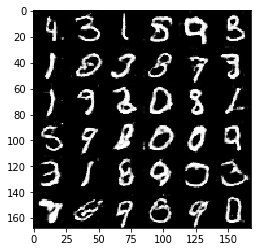

model trained


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 5.0671
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 20.0234
Epoch 1/1... Discriminator Loss: 3.5399... Generator Loss: 22.8991
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 13.7343
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 3.4635
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 3.6818
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 5.0986
Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 3.8395
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.7716
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 2.3114


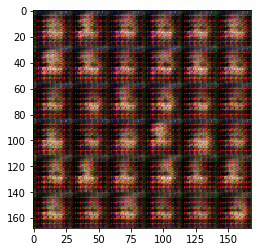

Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 2.0720
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 2.2866
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 3.9292
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.8949... Generator Loss: 5.7992
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 3.0443
Epoch 1/1... Discriminator Loss: 0.7171... Generator Loss: 2.6670


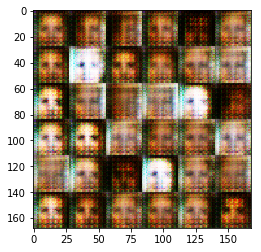

Epoch 1/1... Discriminator Loss: 2.2059... Generator Loss: 4.5199
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 2.9705
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 2.0460... Generator Loss: 0.3655
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.6861
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 3.4304
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 4.6964
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.5477


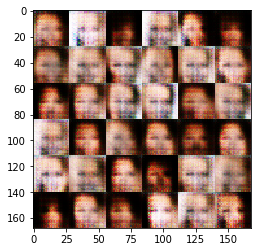

Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 2.2376
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 5.2812
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 2.7152
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.9006
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 0.9225


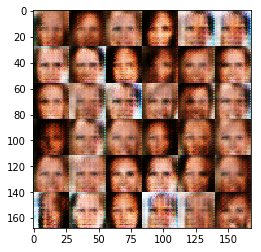

Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.7725
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 2.7013
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.3320
Epoch 1/1... Discriminator Loss: 1.8899... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.5643
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.8838


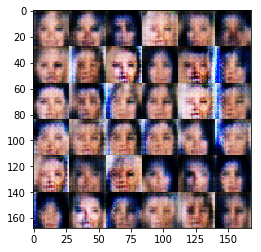

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.9143
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 4.0200
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 2.3678
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.4900
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.9607


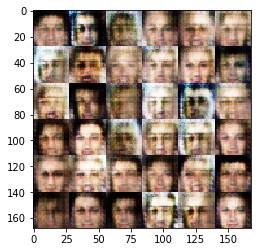

Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 2.1130
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.9084
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.0238


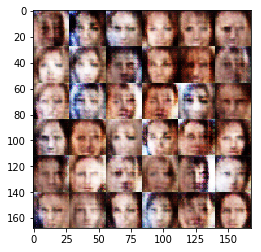

Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 2.0214
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.7536
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.9276
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.9126
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.8566... Generator Loss: 0.4063


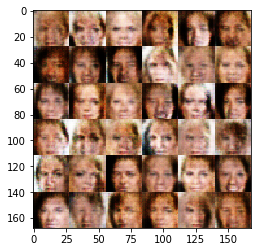

Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 2.8057
Epoch 1/1... Discriminator Loss: 0.6623... Generator Loss: 2.4394
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 3.6860
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 2.6615
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.7012
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 2.2038
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 2.0745
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.5289


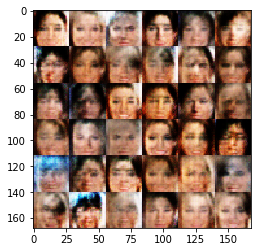

Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 2.8501
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.9852
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 3.4539
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 2.3668
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.9602


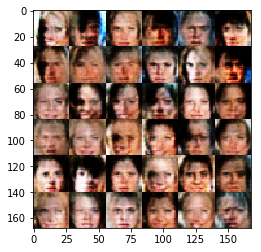

Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.6833
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.6686
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 3.3943
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 3.8365
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 3.1633
Epoch 1/1... Discriminator Loss: 0.4992... Generator Loss: 4.2889


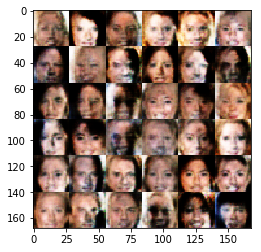

Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 2.7247
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.2492
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.2845
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 2.9751
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 4.9594
Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 4.4048
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 4.3497
Epoch 1/1... Discriminator Loss: 1.7088... Generator Loss: 0.3572


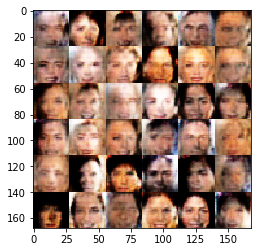

Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.3106
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 0.6864... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.6781
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 2.3914
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 0.7357... Generator Loss: 1.3517


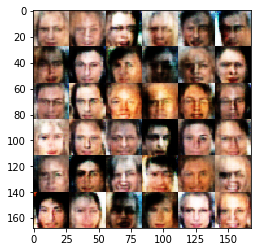

Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 5.6388
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 1.8342
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 6.0870
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 2.2403
Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.8418
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 1.4629
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 2.6892
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 1.1592


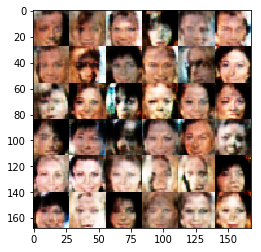

Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.6192
Epoch 1/1... Discriminator Loss: 0.7733... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 2.9084
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 3.5097
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 3.2018
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 1.9657


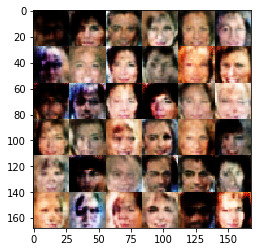

Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 2.9979
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.0067
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 3.0286
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.1986
Epoch 1/1... Discriminator Loss: 0.5847... Generator Loss: 1.9171
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.6818
Epoch 1/1... Discriminator Loss: 2.4788... Generator Loss: 0.1909
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 3.6459
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 1.9706


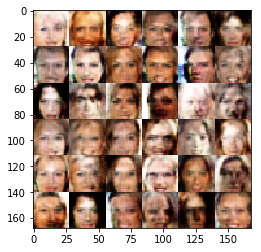

Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 4.2227
Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 1.9360
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 1.9094
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 0.5047... Generator Loss: 2.4807
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 2.5686
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 1.4612
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 2.9041


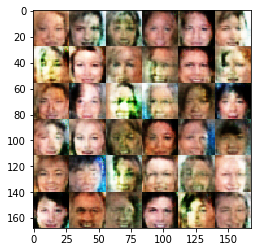

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 4.6250
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 1.9003
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.6182
Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 2.6478
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 1.9409
Epoch 1/1... Discriminator Loss: 0.6271... Generator Loss: 1.8626
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.7056
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 3.6197
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.8156


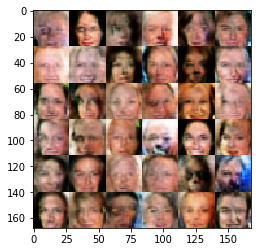

Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 4.5454
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 2.4389
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 2.0556
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.5547
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 2.7378
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.8920
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 3.6764
Epoch 1/1... Discriminator Loss: 1.7450... Generator Loss: 3.7657


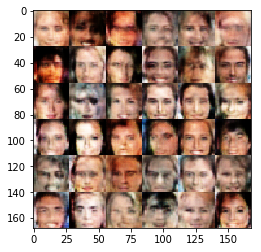

Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.6529
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.6288
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 2.2841
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.2640


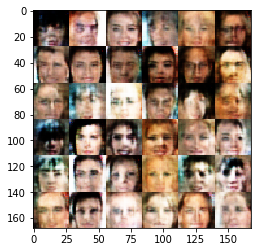

Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 2.5283
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 1.9830
Epoch 1/1... Discriminator Loss: 1.7176... Generator Loss: 3.7014
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.1531


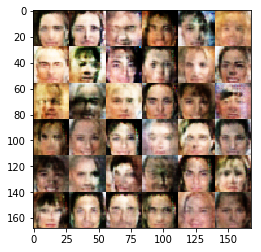

Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 2.7808
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 2.5336
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 2.2583
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.4792
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 1.8532
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 2.1671
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.4168


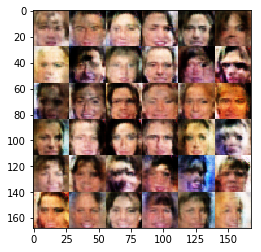

Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 2.5658
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 2.4148
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 4.4761
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.2004
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 2.9690
Epoch 1/1... Discriminator Loss: 0.4170... Generator Loss: 3.1729
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.5032
Epoch 1/1... Discriminator Loss: 0.4505... Generator Loss: 2.7077
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.2428


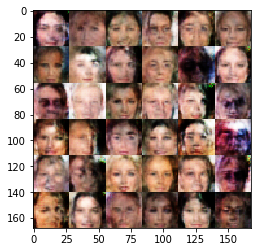

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 4.8539
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 2.1649
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 2.3748
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 2.1626
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 1.5326
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 3.1874
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.1777


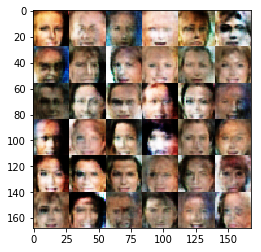

Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.5947
Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.5349
Epoch 1/1... Discriminator Loss: 0.6980... Generator Loss: 1.5391
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.9691
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 2.8949
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 2.2015
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.6907


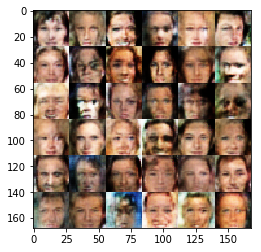

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 3.4172
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 2.6842
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 2.9380
Epoch 1/1... Discriminator Loss: 0.5553... Generator Loss: 1.9118
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.5680
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 2.6016
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6892


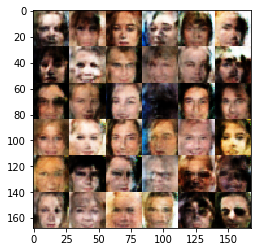

Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.7727
Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 2.1735
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 4.6182
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.8252
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 3.8182
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 3.0699
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 2.7331
Epoch 1/1... Discriminator Loss: 0.4130... Generator Loss: 3.6101
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 1.8667


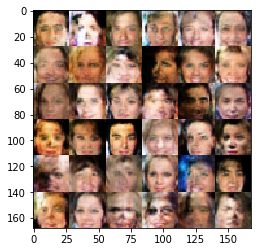

Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 2.5500... Generator Loss: 0.2191
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.5179
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 2.2114
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.3775
Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 3.8123
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 3.8981
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 4.0469


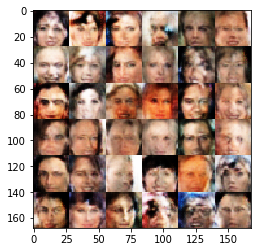

Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 2.3507
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 3.3650
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 1.7005
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 3.2111
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 2.9775
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 2.0197
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 0.6884... Generator Loss: 2.8808
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 3.9086


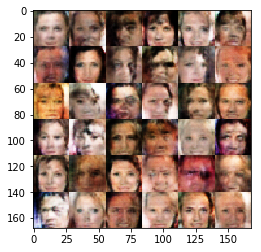

Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 2.9709
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.5379
Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 2.3814
Epoch 1/1... Discriminator Loss: 0.5452... Generator Loss: 2.4260
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 4.5475
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 1.9623
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 2.4859
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.9836
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.5505


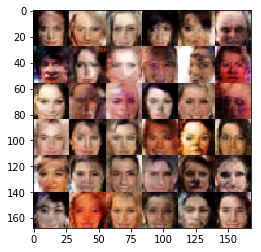

Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.6972
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 1.9145
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.3364
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 2.0078
Epoch 1/1... Discriminator Loss: 0.5051... Generator Loss: 2.5572
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 2.6105
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 2.8122
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 2.1543
Epoch 1/1... Discriminator Loss: 1.7885... Generator Loss: 5.0291


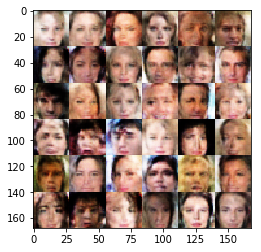

Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 3.1431
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 2.3501
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.3917
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 3.3167
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 2.4352
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 3.2012


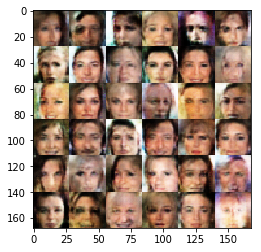

model trained


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.